In [1]:
import ot
import torch

import torch.distributions as D
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from torch.utils import data
from itertools import cycle
from tqdm.auto import trange
from matplotlib.collections import LineCollection
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from geoopt import linalg

from hswfs.chswf import chswf
from hswfs.manifold.euclidean import Euclidean, Mahalanobis

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Utils Trajectories

In [3]:
cdict1 = {'red':   ((0.0, 0.0, 0.0),
                    (0.5, 0.0, 0.1),
                    (1.0, 1.0, 1.0)),

         'green': ((0.0, 0.0, 0.0),
                   (1.0, 0.0, 0.0)),

         'blue':  ((0.0, 0.0, 1.0),
                   (0.5, 0.1, 0.0),
                   (1.0, 0.0, 0.0))
         }

blue_red1 = LinearSegmentedColormap('BlueRed1', cdict1, N=256)


def plot_trajectory(particles, colorbar=False, ax=None, fig=None, log=False):
    x0 = particles[0]
    
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(10,10))


    ts = np.arange(len(particles))
    if log:
        ts[0] = 1
        ts = np.log(ts)
    
    for k in range(x0.shape[0]):
        segments = [np.column_stack([particles[i:i+2,k,0], particles[i:i+2,k,1]]) for i in range(len(particles))]
                
            
        lc = LineCollection(segments, cmap=blue_red1, array=ts)
        line = ax.add_collection(lc)
        

    if colorbar:
        cb = fig.colorbar(line, ax=ax)
        
#     ax.set_yticklabels([])
#     ax.set_xticklabels([])
#     ax.set_xticks([])
#     ax.set_yticks([])

    ax.scatter(x0[:,0], x0[:,1], label="Initial particles", c="blue")
    ax.scatter(particles[-1][:,0], particles[-1][:,1], label="Final particles", c="red")
    
    ax.set_xlim(-3, 7)
    ax.set_ylim(-3, 7)
#     plt.axis("equal")
#     ax.axis("off")

    return line

### Data

In [4]:
n = 15
d = 2
# n_iter = 500

In [5]:
random_state = 42
torch.manual_seed(random_state)

d = 2
l = 10

mu = -l/2 + l * torch.rand((d,), dtype=torch.float32, device=device)
sigma = torch.eye(d, device=device, dtype=torch.float32)

gaussian = D.MultivariateNormal(mu, sigma)

X = gaussian.sample((n,))
ydata = torch.zeros(len(X))

train_dataset = data.TensorDataset(X, ydata)

rand_sampler = torch.utils.data.RandomSampler(train_dataset) #, replacement=True)
train_sampler = torch.utils.data.DataLoader(train_dataset, batch_size=n, sampler=rand_sampler)
dataiter = iter(cycle(train_sampler))

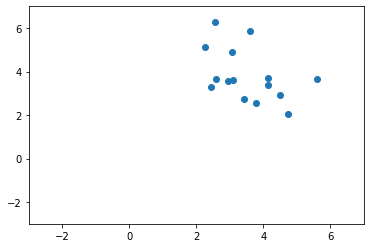

In [6]:
X_target = next(dataiter)[0].cpu().numpy()

plt.scatter(X_target[:,0], X_target[:,1])
plt.xlim(-3, 7)
plt.ylim(-3, 7)
plt.show()

### SWF

In [7]:
manifold = Euclidean(d)

x0 = torch.randn(n, d, device=device)
n_iter = 300

L_swf = chswf(x0, n_iter, dataiter, manifold, tauk=0.1, n_projs=500)

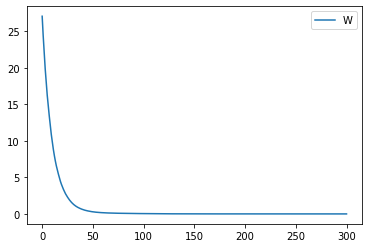

In [8]:
L_w = []

for x in L_swf:
    target = next(dataiter)[0].detach().to(device)
        
    a = torch.ones((n,), device=device)/n
    b = torch.ones((n,), device=device)/n
    
    M = ot.dist(x.to(device), target, metric="sqeuclidean")
        
    w = ot.emd2(a, b, M)
    L_w.append(w.item())


plt.plot(L_w, label="W")
plt.legend()
plt.show()

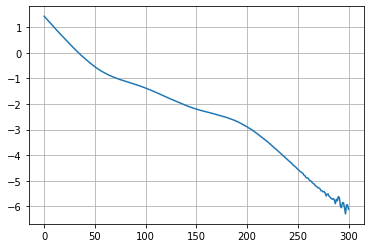

In [9]:
plt.plot(np.log10(np.array(L_w)))
plt.grid(True)
plt.show()

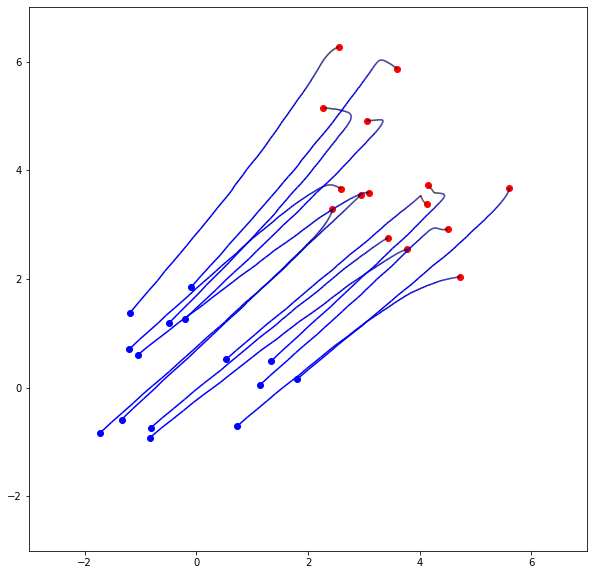

In [10]:
plot_trajectory(np.array([L_swf[k].numpy() for k in range(len(L_swf))]))
plt.show()

### Mahalanobis SWF

In [11]:
# m0 = D.Wishart(torch.tensor([2], dtype=torch.float).to(device), 
#                torch.eye(2, dtype=torch.float, device=device))

# A = m0.sample((1,))[0,0]

# A = torch.tensor([[0.9533, 0.3286], [0.3286, 0.1173]], device=device, dtype=torch.float)

A = torch.tensor([[0.4137, 0.6822], [0.6822, 1.2874]], device=device, dtype=torch.float)

In [12]:
A

tensor([[0.4137, 0.6822],
        [0.6822, 1.2874]])

In [13]:
torch.linalg.eigh(A)[0]

tensor([0.0405, 1.6606])

In [14]:
manifold = Mahalanobis(d, A)

n_iter = 400

L_mah = chswf(x0, n_iter, dataiter, manifold, tauk=0.1, n_projs=500)

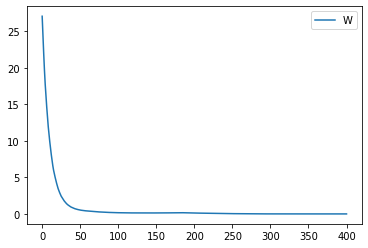

In [15]:
L_w = []

for x in L_mah:
    target = next(dataiter)[0].detach().to(device)
    
    a = torch.ones((n,), device=device)/n
    b = torch.ones((n,), device=device)/n
    
    M = ot.dist(x.to(device), target, metric="sqeuclidean")
        
    w = ot.emd2(a, b, M)
    L_w.append(w.item())


plt.plot(L_w, label="W")
plt.legend()
plt.show()

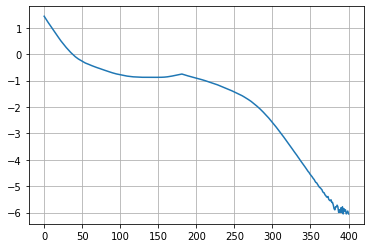

In [16]:
plt.plot(np.log10(np.array(L_w)))
plt.grid(True)
plt.show()

### Plots

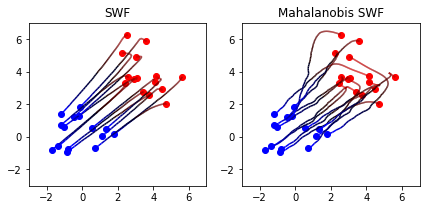

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3))

plot_trajectory(np.array([L_swf[k].numpy() for k in range(len(L_swf))]), ax=ax[0], log=True)
plot_trajectory(np.array([L_mah[k].numpy() for k in range(len(L_mah))]), ax=ax[1], log=True) #, colorbar=True, fig=fig)

ax[0].set_title("SWF")
ax[1].set_title("Mahalanobis SWF")

# plt.savefig("./Trajectories_swf_vs_mswf.pdf", format="pdf", bbox_inches="tight")

plt.show()

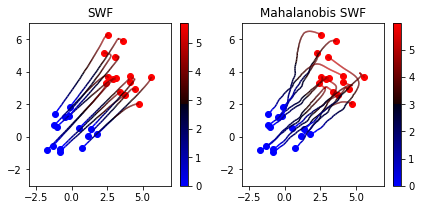

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3))

line1 = plot_trajectory(np.array([L_swf[k].numpy() for k in range(len(L_swf))]), ax=ax[0], log=True)
line2 = plot_trajectory(np.array([L_mah[k].numpy() for k in range(len(L_mah))]), ax=ax[1], log=True) #, colorbar=True, fig=fig)

ax[0].set_title("SWF")
ax[1].set_title("Mahalanobis SWF")

cb = fig.colorbar(line1, ax=ax[0])
cb = fig.colorbar(line2, ax=ax[1])

# plt.savefig("./Trajectories_swf_vs_mswf_cb.pdf", format="pdf", bbox_inches="tight")

plt.show()

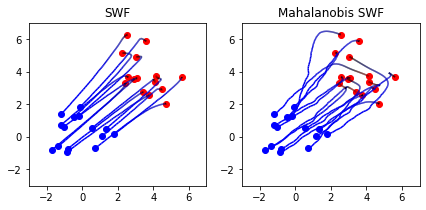

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3))

plot_trajectory(np.array([L_swf[k].numpy() for k in range(len(L_swf))]), ax=ax[0])
plot_trajectory(np.array([L_mah[k].numpy() for k in range(len(L_mah))]), ax=ax[1]) #, colorbar=True, fig=fig)

ax[0].set_title("SWF")
ax[1].set_title("Mahalanobis SWF")

# plt.savefig("./Trajectories_swf_vs_mswf.pdf", format="pdf", bbox_inches="tight")

plt.show()

### Interpolation

In [20]:
def multivariate_gaussian(pos, mu, Sigma):
    """
        Return the multivariate Gaussian distribution on array pos.

        Input:
        - pos is an array constructed by packing the meshed arrays of variables
        x_1, x_2, x_3, ..., x_k into its _last_ dimension.
        - mu: expectation of a gaussian
        - sigma: standard deviation of a gaussian
        
        Source: https://stackoverflow.com/questions/28342968/how-to-plot-a-2d-gaussian-with-different-sigma
    """

    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)

    return np.exp(-fac / 2) / N


def plot_ellipses(mu, sigma, ax=None, xmin=0, xmax=1, levels=10, alpha=1, l=1.5):
    if ax is None:
        ax = plt
    
    xx = np.linspace(xmin,xmax,100)
    yy = np.linspace(xmin,xmax,100)

    XX, YY = np.meshgrid(xx, yy)

    pos = np.empty(XX.shape + (2,))
    pos[:, :, 0] = XX
    pos[:, :, 1] = YY
    
    Z = multivariate_gaussian(pos, mu, sigma)
    
    ax.contour(XX, YY, Z, levels=levels, colors="black", alpha=alpha, linewidths=l) #, colors='blue', cmap="jet")

In [21]:
# A = torch.tensor([[0.9289, 0.3006], [0.3006, 0.1640]], device=device)
A = torch.tensor([[0.4137, 0.6822], [0.6822, 1.2874]], device=device, dtype=torch.float)
A

tensor([[0.4137, 0.6822],
        [0.6822, 1.2874]])

In [22]:
ts = torch.linspace(0, 1, 4)[:,None,None].to(device)
bary_ai = linalg.sym_expm(ts * linalg.sym_logm(A))

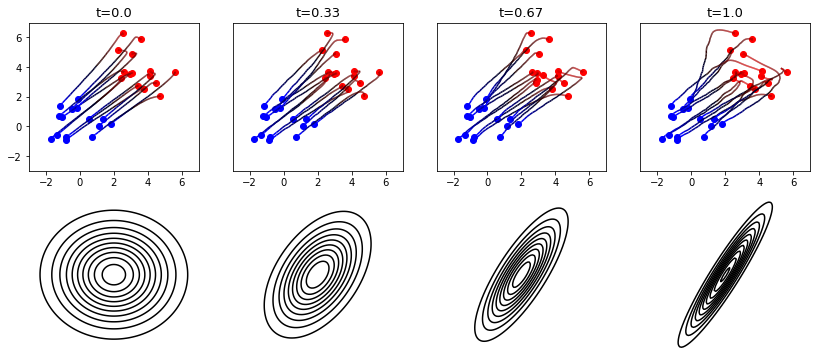

In [23]:
n_iter = 400

fig, ax = plt.subplots(2, 4, figsize=(14, 6))


for i in range(len(ts)):
    At = bary_ai[i]
    manifold = Mahalanobis(d, At)

    L_mah = chswf(x0, n_iter, dataiter, manifold, tauk=0.1, n_projs=500)
    
    plot_trajectory(np.array([L_mah[k].numpy() for k in range(len(L_mah))]), ax=ax[0, i], log=True) #, colorbar=True, fig=fig)
    ax[0, i].set_title("t="+str(round(ts[i].item(), 2)), fontsize=13)
    
    if i>0:
        ax[0, i].set_yticks([])
        
    plot_ellipses(np.array([0,0]), bary_ai[i], xmin=-2.5, xmax=2.5, ax=ax[1, i])
    ax[1, i].axis("off")
    
# plt.savefig("./Trajectories_mahalanobis.pdf", format="pdf", bbox_inches="tight")

plt.show()

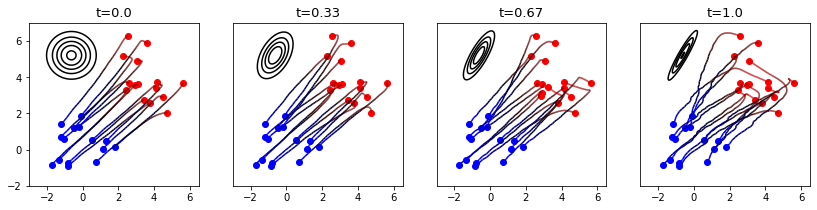

In [24]:
n_iter = 400

fig, ax = plt.subplots(1, 4, figsize=(14, 3))


for i in range(len(ts)):
    At = bary_ai[i]
    manifold = Mahalanobis(d, At)

    L_mah = chswf(x0, n_iter, dataiter, manifold, tauk=0.1, n_projs=500)
    
    plot_trajectory(np.array([L_mah[k].numpy() for k in range(len(L_mah))]), ax=ax[i], log=True) #, colorbar=True, fig=fig)
    ax[i].set_title("t="+str(round(ts[i].item(), 2)), fontsize=13)
    
    if i>0:
        ax[i].set_yticks([])
        
    inset_ax = ax[i].inset_axes([0.05, 0.6, 0.4, 0.4])
        
    plot_ellipses(np.array([0,0]), bary_ai[i], xmin=-2.5, xmax=2.5, ax=inset_ax, levels=5, alpha=1)
    inset_ax.axis("off")
    
    ax[i].set_ylim(-2, 7)
    ax[i].set_xlim(-3, 6.5)
    
# plt.savefig("./Trajectories_mahalanobis_one_row.pdf", format="pdf", bbox_inches="tight")

plt.show()

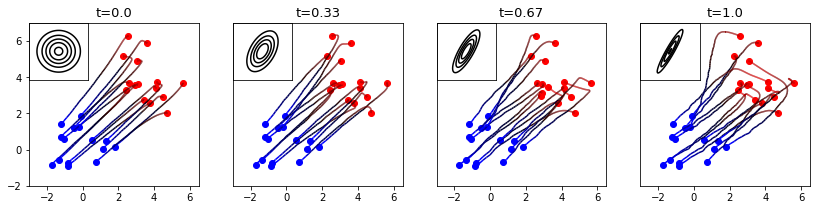

In [25]:
n_iter = 400

fig, ax = plt.subplots(1, 4, figsize=(14, 3))


for i in range(len(ts)):
    At = bary_ai[i]
    manifold = Mahalanobis(d, At)

    L_mah = chswf(x0, n_iter, dataiter, manifold, tauk=0.1, n_projs=500)
    
    plot_trajectory(np.array([L_mah[k].numpy() for k in range(len(L_mah))]), ax=ax[i], log=True) #, colorbar=True, fig=fig)
    ax[i].set_title("t="+str(round(ts[i].item(), 2)), fontsize=13)
    
    if i>0:
        ax[i].set_yticks([])
        
    inset_ax = ax[i].inset_axes([0., 0.65, 0.35, 0.35])
        
    plot_ellipses(np.array([0,0]), bary_ai[i], xmin=-2.5, xmax=2.5, ax=inset_ax, levels=5, alpha=1)
#     inset_ax.axis("off")
    inset_ax.set_xticks([])
    inset_ax.set_yticks([])
    inset_ax.patch.set_alpha(0.1)

    
    ax[i].set_ylim(-2, 7)
    ax[i].set_xlim(-3, 6.5)
    
# plt.savefig("./Trajectories_mahalanobis_one_row.pdf", format="pdf", bbox_inches="tight")

plt.show()

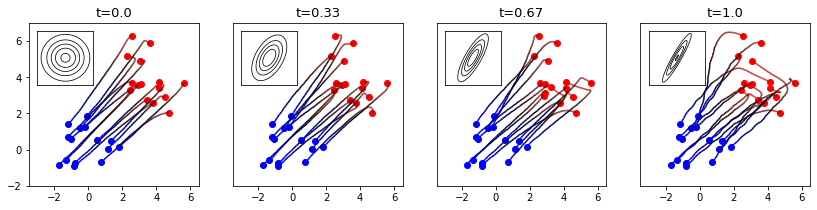

In [26]:
n_iter = 400

fig, ax = plt.subplots(1, 4, figsize=(14, 3))


for i in range(len(ts)):    
    At = bary_ai[i]
    manifold = Mahalanobis(d, At)

    L_mah = chswf(x0, n_iter, dataiter, manifold, tauk=0.1, n_projs=500)
    
    plot_trajectory(np.array([L_mah[k].numpy() for k in range(len(L_mah))]), ax=ax[i], log=True) #, colorbar=True, fig=fig)
    ax[i].set_title("t="+str(round(ts[i].item(), 2)), fontsize=13)
    
    if i>0:
        ax[i].set_yticks([])
        
        
    inset_ax = ax[i].inset_axes([0.05, 0.62, 0.33, 0.33])
        
    plot_ellipses(np.array([0,0]), bary_ai[i], xmin=-2.1, xmax=2.1, ax=inset_ax, levels=5, alpha=1, l=0.75)
#     inset_ax.axis("off")
    inset_ax.set_xticks([])
    inset_ax.set_yticks([])
    inset_ax.patch.set_alpha(0)
#     inset_ax.set_facecolor("none")


    
    ax[i].set_ylim(-2, 7)
    ax[i].set_xlim(-3.5, 6.5)
    
# plt.savefig("./Trajectories_mahalanobis_one_row.pdf", format="pdf", bbox_inches="tight")

plt.show()